In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch

from importlib import reload
from copy import deepcopy
from typing import List
from collections import deque, namedtuple

import random

import utils.plots_cliffwalking as plots


In [15]:
# def encode_state(state: int | torch.Tensor) -> torch.Tensor:
#     if isinstance(state, int):
#         state = torch.tensor(state, dtype=torch.float32)
        
#     x = (state % 12) / 11
#     y = (state // 12) / 3

#     x = x.reshape(-1, 1)
#     y = y.reshape(-1, 1)

#     return torch.cat([x, y], dim=-1)

def encode_state(state: int | torch.Tensor) -> torch.Tensor:
    if isinstance(state, int):
        state = torch.tensor(state, dtype=torch.int64)
    encoded_state = torch.nn.functional.one_hot(state, num_classes=48).to(torch.float32)
    return encoded_state

## Criando o modelo

No Deep Q-Learning, os Q-valores de cada ação associados a um estado são calculados através de uma rede neural. Ou seja, a rede neural recebe como entrada um vetor de estados e deve retornar o vetor de Q-valores onde cada elemento representa o Q-valor de uma ação. Um Q-valor pode ser interpretado como "a recompensa acumulada total esperada por executar a ação A no estado S e depois seguir a mesma política até o final do episódio".

Por se tratar de um problema relativamente simples, o modelo para solucionar o CliffWalking pode ser uma rede MLP. Além disso, note que a predição dos Q-valores é uma tarefa de regressão, portanto não é utilizada uma função de ativação softmax no final da rede. 

In [3]:
class Qnet(torch.nn.Module):
    def __init__(self, layer_sizes: List[int] = [], n_actions: int = 4):
        super().__init__()

        # construindo a rede neural
        layers = []
        input_size = 48 # entrada: estado codificado em one-hot
        for n_neurons in layer_sizes:
            layers.append(torch.nn.Linear(input_size, n_neurons))
            layers.append(torch.nn.ReLU())
            input_size = n_neurons
        layers.append(torch.nn.Linear(input_size, n_actions))
        self.nn = torch.nn.Sequential(*layers)

    def initialize(self):
        # inicializa os pesos da rede
        for layer in self.nn:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
                layer.bias.data.fill_(0.01)

    def forward(self, x):
        x = encode_state(x)
        x = self.nn(x)
        return x

## Replay buffer

Replay buffers são utilizados (...)


In [22]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity=1024, backup_fraq=0.1):
        self.backup_size = int(backup_fraq * capacity)
        self.memory_size = capacity - self.backup_size
        self.memory = deque([], maxlen=self.memory_size)
        self.backup = []
        self.buffer = []
    
    def push(self, *args):
        """ Inserts a transition in the buffer. The first `capacity * backup_frac` transitions are stored in a backup list and
        they're not discarded. The next transitions are stored in a deque and they're discarded when the buffer is full.
        """

        if len(self.backup) < self.backup_size:
            self.backup.append(Transition(*deepcopy(args)))
        else:
            self.memory.append(Transition(*deepcopy(args)))
        
        self.buffer = self.backup + list(self.memory)
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

## Amostrando ações com a política $\epsilon$-greedy

No final do treinamento, espera-se que a melhor ação para cada estado seja aquela cujo Q-Valor é o maior. No entanto, para que o Q-Learning convirja adequadamente, é necessário que no início do treinamento o agente "explore" bem o ambiente. Isto é, que o agente visite um grande número de estados mesmo que não sejam necessariamente ótimos. Uma técnica amplamente utilizada para essa finalidade é a política $\epsilon$-greedy. Ela consiste em forçar o agente a escolher ações aleatoriamente com uma frequência que diminui conforme o treinamento avança.

In [23]:
@torch.no_grad()
def get_action(model, state, epsilon=0, random=True, n_actions=4):
    if torch.rand(1) < epsilon and random:
        return torch.randint(n_actions, (1,)).item()
    qvals = model(state)
    return torch.argmax(qvals).item()

## Treinamento da rede neural 

A cada passo do treinamento, o agente executará uma ação e utilizará a informação retornada pelo ambiente para calcular uma loss e atualizar seus pesos de forma a minimizá-la. A loss que será utilizada é o erro quadrático médio entre o Q-valor escolhido e o maior Q-valor do próximo estado calculado utilizando a rede com os pesos anteriores à ultima atualização:

$$L_i(\theta_i)=\mathbb{E}[(y_i - Q(s,a;\theta_i))^2]$$
$$y_i=\mathbb{E}[R(s')+\gamma\max_A Q(s',A;\theta_{i-1})]$$

Note que, portanto, serão necessárias duas redes neurais com a mesma arquitetura, mas uma terá os pesos deefasados em uma iteração com relação à outra.

In [24]:
def update_q_net(
                model: Qnet, 
                model_target: Qnet,
                optimizer: torch.optim.Optimizer, 
                batch_of_transitions: List[Transition],
                gamma):
    
    # convertendo uma lista de Transitions para uma Transition de listas
    # mais informacoes: https://stackoverflow.com/questions/19339/transpose-unzip-function-inverse-of-zip/19343#19343
    batch = Transition(*zip(*batch_of_transitions))
    
    # transformando o batch de estados em um tensor
    states = torch.tensor(batch.state)
    actions = torch.tensor(batch.action)
    rewards = torch.tensor(batch.reward)
    next_states = torch.tensor(batch.next_state)
    terminated = torch.tensor(batch.done)
    
    optimizer.zero_grad()
    qvals = model(states)
    predictions = torch.gather(qvals, 1, actions.unsqueeze(1)) # seleciona o qval da acao tomada

    # se o estado é terminal, o valor é a recompensa
    with torch.no_grad():
        targets = rewards + gamma * torch.max(model_target(next_states), dim=-1).values * (1 - terminated.to(torch.int))
    
    loss = torch.nn.functional.mse_loss(predictions, targets)
    loss.backward()

    # atualizando os pesos da rede
    optimizer.step()

    return model

## Loop de treinamento

No loop de treinamento, juntaremos todas as funções desenvolvidas até o momento. A ideia principal é definir um número máximo de episódios (estágio inicial até o estágio final) para que o agente colete experiências do ambiente e otimize sua tabela de QValores.

In [25]:
class Heatmap:
    def __init__(self, rows, cols):
        self.heatmap = torch.zeros(rows, cols)
    
    def record_step(self, state):
        col = state % 12
        row = state // 12
        self.heatmap[row][col] += 1

    def clear(self):
        self.heatmap = torch.zeros(self.heatmap.shape)
    
    def plot(self):
        print(self.heatmap.int())
        plt.imshow(self.heatmap, cmap='hot', interpolation='nearest')
        plt.title(f'Heatmap on batch of 20 eps')
        plt.show()

In [41]:
debug_model = None

def train(
        env: gym.Env, 
        model: Qnet,
        total_timesteps=500000, # numero maximo de episodios
        learning_rate=2.5e-4, # taxa de aprendizado
        replay_buffer_size=100000, # tamanho do replay buffer
        gamma=0.99, # fator de desconto
        tau = 1.0, # fator de mistura para atualizacao da rede defasada
        target_update_freq = 500, # frequencia de atualizacao da rede defasada
        batch_size=128, # tamanho do batch
        epsilon_0 = 1, # probabilidade inicial de escolher uma ação aleatória
        epsilon_f=0.05, # probabilidade final de escolher uma ação aleatória (após o decaimento)
        exploration_fraction = 0.5, # fracao do total de timesteps para ir de epsilon_0 até epsilon_f
        learn_starts_in = 10000, # numero de timesteps antes de comecar a treinar
        learning_freq = 10, # frequencia de treinamento
        evaluation_freq = 10000, # frequencia de avaliacao
        verbose=False):
    
    model_target = deepcopy(model)
    eval_env = deepcopy(env)

    model.initialize()
    model_target.initialize()

    def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
        slope = (end_e - start_e) / duration
        return max(slope * t + start_e, end_e)

    replay_buffer = ReplayBuffer(replay_buffer_size, 0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    
    avg_rewards = []
    evaluation_steps = []
    heatmap = Heatmap(4, 12)
    state, _ = env.reset()
    done = False

    for global_step in range(total_timesteps):
        
        epsilon = linear_schedule(epsilon_0, epsilon_f, int(exploration_fraction * total_timesteps), global_step)

        # observe
        action = get_action(model, state, epsilon)
        next_state, reward, terminated, _, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, terminated)
        state = next_state
        if terminated:
            state, _ = env.reset()

        # update
        if global_step > learn_starts_in and global_step % learning_freq == 0:
            batch = replay_buffer.sample(batch_size)
            model = update_q_net(model, model_target, optimizer, batch, gamma)

        # update target network
        if global_step % target_update_freq == 0:
            model_target.load_state_dict(model.state_dict())

        # evaluating
        if global_step % evaluation_freq == 0 and verbose:
            clear_output(wait=True)
            # debug_model.load_state_dict(model.state_dict())

            total_rewards = []
            for _ in range(20):
                state, _ = eval_env.reset()
                done = False
                total_reward = 0
                step = 0
                while not done and step < 100:
                    action = get_action(model, state, epsilon, random=True)
                    state, reward, terminated, _, _ = eval_env.step(action)
                    total_reward += reward
                    heatmap.record_step(state)
                    step += 1
                    done = terminated
                    
                total_rewards.append(total_reward)
            
            avg_reward = sum(total_rewards) / len(total_rewards)
            avg_rewards.append(avg_reward)
            evaluation_steps.append(global_step)

            print(f"Global step {global_step} - Average total reward: {avg_reward} - epsilon: {epsilon}")

            plt.plot(evaluation_steps, avg_rewards)
            plt.show()

            heatmap.plot()
            heatmap.clear()

            # dump q table
            with torch.no_grad():
                for state in range(48):
                    if state in range(37, 48):
                        continue
                    print(f'state {state}: {model(state).detach().numpy()}')

            plots.plot_arrows_from_qnet(model)
            
            debug_model.load_state_dict(model.state_dict())

    return model

## Treinando

Está tudo configurado, portanto agora podemos rodar o algoritmo!

Global step 190000 - Average total reward: -520.75 - epsilon: 0.24380000000000002


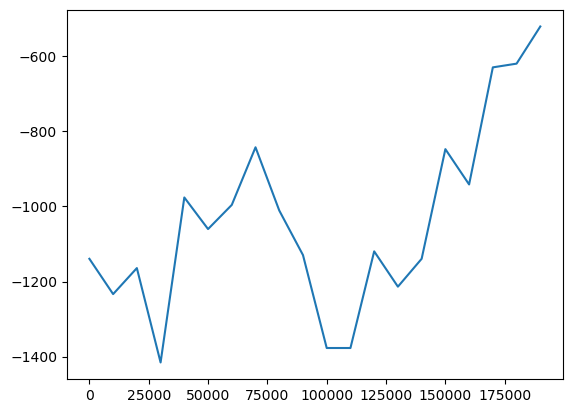

tensor([[ 270,   66,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [  40,    8,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 118,   11,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [1478,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
       dtype=torch.int32)


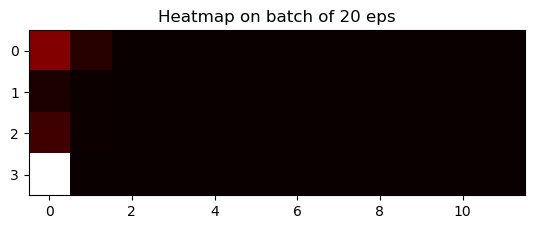

state 0: [-2.788556  -3.5069208 -2.7988482 -2.7452607]
state 1: [-2.619184  -3.2306035 -2.6554244 -2.7696657]
state 2: [-2.8163366 -3.1960454 -2.632438  -2.6599457]
state 3: [-2.9703493 -3.3294346 -3.1226265 -2.8543255]
state 4: [-2.9561667 -3.256323  -2.6847162 -2.470137 ]
state 5: [-2.416348  -2.9899247 -2.6403186 -2.6376898]
state 6: [-2.773546  -3.4070933 -2.631401  -2.8070915]
state 7: [-2.3811712 -2.8710637 -2.3272607 -2.5539687]
state 8: [-2.210376  -2.6798055 -2.3583112 -2.3202407]
state 9: [-2.0001607 -2.4875543 -1.8763542 -2.0890248]
state 10: [-2.5272264 -3.081441  -2.6097374 -2.4838967]
state 11: [-2.6957502 -3.0291908 -2.5117443 -2.747646 ]
state 12: [-2.8860364 -3.5750175 -2.93577   -2.955879 ]
state 13: [-3.0624447 -3.1988535 -2.745756  -2.5509183]
state 14: [-2.9187076 -3.3685782 -2.6058183 -2.7125242]
state 15: [-2.1727283 -2.298407  -2.1519735 -2.1491811]
state 16: [-2.6627102 -3.2626379 -2.931671  -3.0399902]
state 17: [-3.1027453 -3.4717388 -2.5791888 -2.65638  ]
st

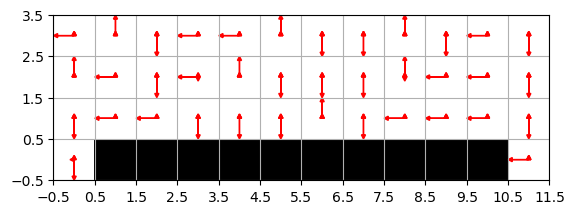

KeyboardInterrupt: 

In [42]:
import env.cliff_walking as env
#reload(env)

cliff_walking = gym.make('CliffWalking-v0')
q_net = Qnet(layer_sizes=[64, 32])
debug_model = deepcopy(q_net)
trained_q_net = train(
    cliff_walking, 
    q_net,
    learning_rate=5e-6,
    epsilon_f=0.005, 
    verbose=True)

In [ ]:
env=gym.make('CliffWalking-v0')
print(env.observation_space.n)

48


## Testando o agente

A função abaixo rodará um episódio com o agente já treinado.

In [ ]:
def test(env: gym.Env, 
          q_net,
          n_episodes=1,
          verbose=False
          ):
    
    total_rewards = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = get_action(q_net, state, 0)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            done = terminated or truncated

        if verbose:
            print(f"Episode {episode} - Total reward: {total_reward}")
            
        total_rewards.append(total_reward)

    env.close()
    return torch.mean(total_reward)

test(gym.make('CliffWalking-v0', render_mode="human"), trained_q_net)

KeyboardInterrupt: 

## Análise de resultados

### Visualizando a política

A célula abaixo permitirá observar a ação mais provável de ser tomada em cada uma das posições do tabuleiro.

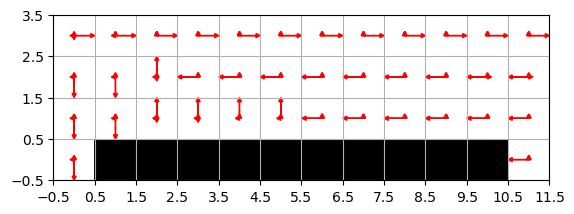

In [ ]:
reload(plots)
plots.plot_arrows_from_qnet(debug_model)

In [ ]:
for state in range(48):
    print(f'state {state}: {debug_model(state).detach().numpy()}')

state 0: [[-0.26136434 -0.26724744 -0.23699465 -0.3733187 ]]
state 1: [[-0.27144846 -0.26728043 -0.24119844 -0.37571108]]
state 2: [[-0.28178144 -0.26390606 -0.2476211  -0.39044908]]
state 3: [[-0.2997111  -0.26615438 -0.26275432 -0.41584584]]
state 4: [[-0.32363167 -0.27345696 -0.281278   -0.44857207]]
state 5: [[-0.3505416  -0.2850831  -0.30246425 -0.48349568]]
state 6: [[-0.37939647 -0.2969428  -0.32455295 -0.518417  ]]
state 7: [[-0.4085074  -0.30842635 -0.3466031  -0.5534043 ]]
state 8: [[-0.43703473 -0.31941727 -0.36920953 -0.5884064 ]]
state 9: [[-0.46534702 -0.3298886  -0.39209569 -0.6232178 ]]
state 10: [[-0.49470758 -0.3404794  -0.4149565  -0.6574695 ]]
state 11: [[-0.52414346 -0.35103914 -0.43799382 -0.6916231 ]]
state 12: [[-0.38011822 -0.4195511  -0.38666034 -0.5301238 ]]
state 13: [[-0.39039123 -0.4392437  -0.38741583 -0.53646696]]
state 14: [[-0.40114212 -0.46237087 -0.38874257 -0.5412873 ]]
state 15: [[-0.4145421 -0.4800888 -0.3915658 -0.5552423]]
state 16: [[-0.4321601

### Visualizando a influência da taxa de aprendizado

A célula abaixo criará um gráfico com a recompensa total média de um conjunto de agentes treinados com uma diferente taxa de aprendizado. Como você explicaria os resultados?

In [ ]:
# retorno médio esperado em função de alpha

def plot_avg_return_x_alpha(n_samples=100, n_alphas=10 ):
    avg_returns = []
    alphas=np.linspace(0.1, 1, n_alphas)
 
    for alpha in alphas:
        q_table = new_q_table(n_states=48, n_actions=4)
        trained_q_table = train(cliff_walking, q_table, alpha=alpha)
        avg_returns.append(test(cliff_walking, trained_q_table, n_samples))

    plt.plot(alphas, avg_returns)
    plt.grid()
    plt.show()

plot_avg_return_x_alpha(n_samples=100, n_alphas=10)

NameError: name 'np' is not defined

## Exercício - ambientes não-determinísticos

Agora que já vimos que o agente aprendeu um caminho para o objetivo que minimiza a distância caminhada e não cai no penhasco, está na hora de deixar as coisas um pouco mais difíceis. Utilizaremos agora uma versão modificada do Cliff Walking que adiciona vento aleatório na direção do penhasco. Ou seja, existe uma probabilidade do agente ser deslocado uma casa para baixo de maneira involuntária.

Essa alteração será interessante para observarmos a infuência da taxa de aprendizado no treinamento de um modelo robusto a ambientes não-determinísticos.

In [ ]:
windy_cliff_walking = WindyCliffWalking(wind=0.5)

windy_q_table = new_q_table(n_states=48, n_actions=4)
trained_windy_q_table = train(cliff_walking, windy_q_table, alpha=0.75, verbose=True)

### Resultados

In [ ]:
windy_cliff_walking.render_mode = 'human'
test(windy_cliff_walking, trained_windy_q_table)

In [ ]:
plots.plot_arrows(trained_q_table)